# Постановка задачи

- Изменить функцию потерь, чтобы учитывать стили с двух картинок. Основа для одной картики как и в семинаре, взята с [Neural Transfer Using PyTorch](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)
- Реализовать [Universal Style Transfer via Feature Transforms](https://arxiv.org/pdf/1705.08086.pdf) для двух стилей
- Сравнить результаты

# Neural Style Transfer

- [**Original paper**](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)


## Underlying Principle

The principle is simple: we define two distances, one for the content
($D_C$) and one for the style ($D_S$). $D_C$ measures how different the content
is between two images while $D_S$ measures how different the style is
between two images. Then, we take a third image, the input, and
transform it to minimize both its content-distance with the
content-image and its style-distance with the style-image. Now we can
import the necessary packages and begin the neural transfer.

## Краткий конспект оригинальной статьи

#### 1. Content representation

Let $ \overrightarrow{p} $ and $ \overrightarrow{x} $ be the original image and the image that is generated, and $P^l$ and $F^l$ their respective feature representation in layer $l$. We then definethe squared-error loss between the two feature representations

$$ L_{content}(\overrightarrow{p},\overrightarrow{x},l) = \frac{1}{2}\sum_{i,j}(F^l_{ij} - P^l_{ij})^2 $$

#### 2. Style representation

To obtain a representation of thestyleof an input image, we use a feature space designed to capture texture informa-tion. This feature space can be built on top of the filter responses in any layer of the network. It consists of the correlations between the different filter responses, where the expectation is taken over the spatial extent of the feature maps. These feature correlations are given by the Gram matrix $G^l ∈ R^{N_l×N_l} $, where $G^l_{ij}$ is the inner product between the vectorised feature maps $i$ and $j$ in layer $l$:

$$ G^l_{ij} = \sum_{k}F^L_{ik}F^l_{jk} $$

Let $\overrightarrow{a}$ and $\overrightarrow{x}$ be the original image and the image that is generated, and $A^l$ and $G^l$ their respective style representation in layer $l$. The contribution of layer $l$ to the total loss is then

$$ E_l = \frac{1}{4N_l^2M_l^2}\sum_{i,j}(G^l_{ij} - A^l_{ij})^2 $$

and the total style loss is

$$ L_{style}(\overrightarrow{a},\overrightarrow{x}) = \sum_{l=0}^L\omega_lE_l $$

#### 3. Style transfer

To transfer the style of an artwork $\overrightarrow{a}$ onto a photograph $\overrightarrow{p}$ we synthesise a new image that simultaneously matches the content representation of $\overrightarrow{p}$ and the style representation of $\overrightarrow{a}$. Thus we jointly minimise the distance of the feature representations of a white noise image from the content representation of the photograph in one layer and the style representation of the painting defined on a number of layers of the Convolutional Neural Network. The loss function we minimise is

$$ L_{total}(\overrightarrow{p},\overrightarrow{a},\overrightarrow{x}) = \alpha L_{content}(\overrightarrow{p},\overrightarrow{x}) + \beta L_{style}(\overrightarrow{a},\overrightarrow{x})$$

## Importing Packages and Selecting a Device

In [1]:
# %load ../../temp/snippets/imports.py
import os
import time
import pickle
import copy
from skimage import io
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={"figure.figsize": (10, 6),
            "grid.linewidth": 0})
%config InlineBackend.figure_format = "retina"

import PIL
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision.transforms as transforms
import torchvision.models as models

from pandas_profiling import ProfileReport
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading the Images
------------------

Now we will import the style and content images. The original PIL images have values between 0 and 255, but when
transformed into torch tensors, their values are converted to be between
0 and 1. The images also need to be resized to have the same dimensions.
An important detail to note is that neural networks from the
torch library are trained with tensor values ranging from 0 to 1. If you
try to feed the networks with 0 to 255 tensor images, then the activated
feature maps will be unable to sense the intended content and style.
However, pre-trained networks from the Caffe library are trained with 0
to 255 tensor images. 

In [2]:
# desired size of the output image
imsize = 190 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


content_img = image_loader("images/man.jpg")
style_img = image_loader("images/cubism.jpg")
style_img2 = image_loader("images/abstract1.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

Now, let's create a function that displays an image by reconverting a 
copy of it to PIL format and displaying the copy using 
``plt.imshow``. We will try displaying the content and style images 
to ensure they were imported correctly.



In [3]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    
    
def to_show(tensor):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    return image


# f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    
# ax1.imshow(to_show(content_img))
# ax2.imshow(to_show(style_img))
# ax3.imshow(to_show(style_img2))

# ax1.set_title('Content')
# ax2.set_title('Style 1')
# ax3.set_title('Style 2');

Loss Functions
--------------



In [4]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [5]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [6]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input
    

class StyleLoss2(nn.Module):

    def __init__(self, target_feature1, target_feature2):
        super(StyleLoss2, self).__init__()
        self.target1 = gram_matrix(target_feature1).detach()
        self.target2 = gram_matrix(target_feature2).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target1) + F.mse_loss(G, self.target2)
        return input

Importing the Model
-------------------

Now we need to import a pre-trained neural network. We will use a 19
layer VGG network like the one used in the paper.

PyTorch’s implementation of VGG is a module divided into two child
``Sequential`` modules: ``features`` (containing convolution and pooling layers),
and ``classifier`` (containing fully connected layers). We will use the
``features`` module because we need the output of the individual
convolution layers to measure content and style loss. Some layers have
different behavior during training than evaluation, so we must set the
network to evaluation mode using ``.eval()``.




In [7]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Additionally, VGG networks are trained on images with each channel
normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
We will use them to normalize the image before sending it into the network.




In [8]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

A ``Sequential`` module contains an ordered list of child modules. For
instance, ``vgg19.features`` contains a sequence (Conv2d, ReLU, MaxPool2d,
Conv2d, ReLU…) aligned in the right order of depth. We need to add our
content loss and style loss layers immediately after the convolution
layer they are detecting. To do this we must create a new ``Sequential``
module that has content loss and style loss modules correctly inserted.




In [9]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               second_style, style_img2,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            if second_style == False:
                target_feature = model(style_img).detach()
                style_loss = StyleLoss(target_feature)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)
            else:
                target_feature1 = model(style_img).detach()
                target_feature2 = model(style_img2).detach()
                style_loss = StyleLoss2(target_feature1, target_feature2)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)
                

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss2):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

Next, we select the input image. You can use a copy of the content image
or white noise.




In [10]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
# plt.figure()
# imshow(input_img, title='Input Image')

Gradient Descent
----------------

As Leon Gatys, the author of the algorithm, suggested `here <https://discuss.pytorch.org/t/pytorch-tutorial-for-neural-transfert-of-artistic-style/336/20?u=alexis-jacq>`__, we will use
L-BFGS algorithm to run our gradient descent. Unlike training a network,
we want to train the input image in order to minimise the content/style
losses. We will create a PyTorch L-BFGS optimizer ``optim.LBFGS`` and pass
our image to it as the tensor to optimize.




In [11]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

Finally, we must define a function that performs the neural transfer. For
each iteration of the networks, it is fed an updated input and computes
new losses. We will run the ``backward`` methods of each loss module to
dynamicaly compute their gradients. The optimizer requires a “closure”
function, which reevaluates the module and returns the loss.

We still have one final constraint to address. The network may try to
optimize the input with values that exceed the 0 to 1 tensor range for
the image. We can address this by correcting the input values to be
between 0 to 1 each time the network is run.




In [12]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, second_style, style_img2, num_steps=700,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img, second_style, style_img2)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Finally, we can run the algorithm.




Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 10637.494141 Content Loss: 19.475708

run [100]:
Style Loss : 10474.679688 Content Loss: 20.855669

run [150]:
Style Loss : 10437.350586 Content Loss: 21.334784

run [200]:
Style Loss : 10421.126953 Content Loss: 21.420185

run [250]:
Style Loss : 10413.045898 Content Loss: 21.289209

run [300]:
Style Loss : 10408.487305 Content Loss: 20.988926

run [350]:
Style Loss : 10405.554688 Content Loss: 20.630322

run [400]:
Style Loss : 10403.729492 Content Loss: 20.268616

run [450]:
Style Loss : 10402.552734 Content Loss: 19.909212

run [500]:
Style Loss : 10401.724609 Content Loss: 19.575548

run [550]:
Style Loss : 10401.157227 Content Loss: 19.294655

run [600]:
Style Loss : 10400.728516 Content Loss: 19.034567

run [650]:
Style Loss : 10400.434570 Content Loss: 18.803812

run [700]:
Style Loss : 10400.185547 Content Loss: 18.590891



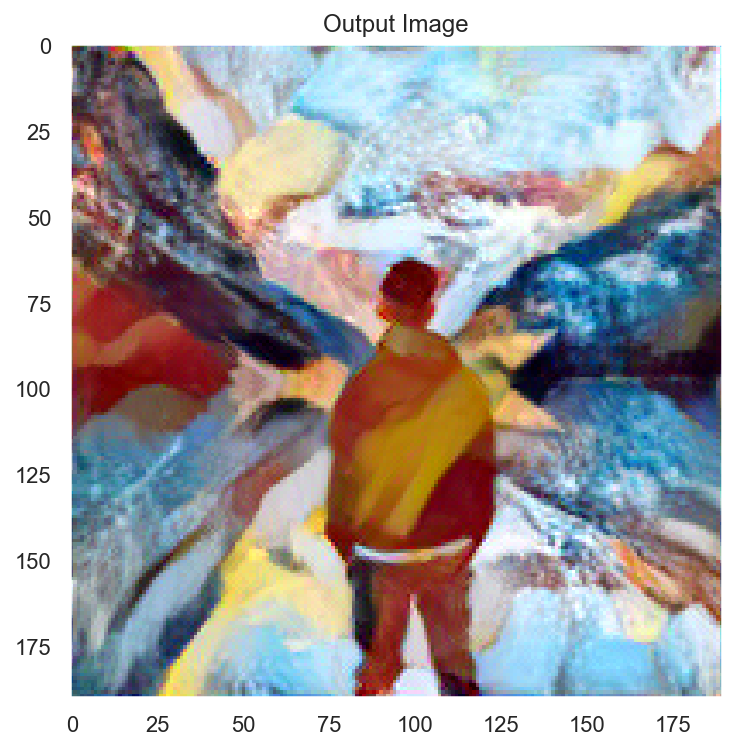

In [13]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, True, style_img2)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

# Universal Style Transfer via Feature Transforms

- [Show, Divide and Neural: Weighted Style Transfer](http://cs231n.stanford.edu/reports/2016/pdfs/208_Report.pdf)
- [Localized Style Transfer](http://cs231n.stanford.edu/reports/2017/pdfs/416.pdf)
- [Preserving Color in Neural Artistic Style Transfer](https://arxiv.org/pdf/1606.05897.pdf)

Сделаем рализацию концепции, представленной в этой статье, основываясь на оригинальной реализации
- [**Universal Style Transfer via Feature Transforms**](https://arxiv.org/pdf/1705.08086.pdf)

## Основная идея

We construct an auto-encoder network for general image reconstruction. We employ the VGG-19 as the encoder, fix it and train a decoder network simply for inverting VGG features to the original image. The decoder is designed as being symmetrical to that of VGG-19 network (up to Relu_X_1 layer), with the nearest neighbor upsampling layer used for enlarging feature maps. To evaluate with features extracted at different layers, we select feature maps at five layers of the VGG-19, i.e., Relu_X_1 (X=1,2,3,4,5), and train five decoders accordingly. The pixel reconstruction loss and feature loss are employed for reconstructing an input image.

In [14]:
from models.autoencoder_vgg19.vgg19_1 import vgg_normalised_conv1_1, feature_invertor_conv1_1
from models.autoencoder_vgg19.vgg19_2 import vgg_normalised_conv2_1, feature_invertor_conv2_1
from models.autoencoder_vgg19.vgg19_3 import vgg_normalised_conv3_1, feature_invertor_conv3_1
from models.autoencoder_vgg19.vgg19_4 import vgg_normalised_conv4_1, feature_invertor_conv4_1
from models.autoencoder_vgg19.vgg19_5 import vgg_normalised_conv5_1, feature_invertor_conv5_1


class Encoder(nn.Module):

    def __init__(self, depth):
        super(Encoder, self).__init__()

        self.depth = depth

        if depth == 1:
            self.model = vgg_normalised_conv1_1.vgg_normalised_conv1_1
            self.model.load_state_dict(torch.load("models/autoencoder_vgg19/vgg19_1/vgg_normalised_conv1_1.pth"))
        elif depth == 2:
            self.model = vgg_normalised_conv2_1.vgg_normalised_conv2_1
            self.model.load_state_dict(torch.load("models/autoencoder_vgg19/vgg19_2/vgg_normalised_conv2_1.pth"))
        elif depth == 3:
            self.model = vgg_normalised_conv3_1.vgg_normalised_conv3_1
            self.model.load_state_dict(torch.load("models/autoencoder_vgg19/vgg19_3/vgg_normalised_conv3_1.pth"))
        elif depth == 4:
            self.model = vgg_normalised_conv4_1.vgg_normalised_conv4_1
            self.model.load_state_dict(torch.load("models/autoencoder_vgg19/vgg19_4/vgg_normalised_conv4_1.pth"))
        elif depth == 5:
            self.model = vgg_normalised_conv5_1.vgg_normalised_conv5_1
            self.model.load_state_dict(torch.load("models/autoencoder_vgg19/vgg19_5/vgg_normalised_conv5_1.pth"))


    def forward(self, x):
        out = self.model(x)
        return out


class Decoder(nn.Module):
    def __init__(self, depth):
        super(Decoder, self).__init__()

        self.depth = depth

        if depth == 1:
            self.model = feature_invertor_conv1_1.feature_invertor_conv1_1
            self.model.load_state_dict(torch.load("models/autoencoder_vgg19/vgg19_1/feature_invertor_conv1_1.pth"))
        elif depth == 2:
            self.model = feature_invertor_conv2_1.feature_invertor_conv2_1
            self.model.load_state_dict(torch.load("models/autoencoder_vgg19/vgg19_2/feature_invertor_conv2_1.pth"))
        elif depth == 3:
            self.model = feature_invertor_conv3_1.feature_invertor_conv3_1
            self.model.load_state_dict(torch.load("models/autoencoder_vgg19/vgg19_3/feature_invertor_conv3_1.pth"))
        elif depth == 4:
            self.model = feature_invertor_conv4_1.feature_invertor_conv4_1
            self.model.load_state_dict(torch.load("models/autoencoder_vgg19/vgg19_4/feature_invertor_conv4_1.pth"))
        elif depth == 5:
            self.model = feature_invertor_conv5_1.feature_invertor_conv5_1
            self.model.load_state_dict(torch.load("models/autoencoder_vgg19/vgg19_5/feature_invertor_conv5_1.pth"))

    def forward(self, x):
        out = self.model(x)
        return out

WCT функция, взятая и дополненная из оригинальной реализации

In [15]:
def wct(alpha, cf, sf, s1f=None, beta=None):

    cf = cf.double()
    c_channels, c_width, c_height = cf.size(0), cf.size(1), cf.size(2)
    cfv = cf.view(c_channels, -1)

    c_mean = torch.mean(cfv, 1)
    c_mean = c_mean.unsqueeze(1).expand_as(cfv)
    cfv = cfv - c_mean

    c_covm = torch.mm(cfv, cfv.t()).div((c_width * c_height) - 1)
    c_u, c_e, c_v = torch.svd(c_covm, some=False)

    k_c = c_channels
    for i in range(c_channels):
        if c_e[i] < 0.00001:
            k_c = i
            break
    c_d = (c_e[0:k_c]).pow(-0.5)

    w_step1 = torch.mm(c_v[:, 0:k_c], torch.diag(c_d))
    w_step2 = torch.mm(w_step1, (c_v[:, 0:k_c].t()))
    whitened = torch.mm(w_step2, cfv)

    # style image coloring
    sf = sf.double()
    _, s_width, s_heigth = sf.size(0), sf.size(1), sf.size(2)
    sfv = sf.view(c_channels, -1)

    s_mean = torch.mean(sfv, 1)
    s_mean = s_mean.unsqueeze(1).expand_as(sfv)
    sfv = sfv - s_mean

    s_covm = torch.mm(sfv, sfv.t()).div((s_width * s_heigth) - 1)
    s_u, s_e, s_v = torch.svd(s_covm, some=False)

    s_k = c_channels
    for i in range(c_channels):
        if s_e[i] < 0.00001:
            s_k = i
            break
    s_d = (s_e[0:s_k]).pow(0.5)

    c_step1 = torch.mm(s_v[:, 0:s_k], torch.diag(s_d))
    c_step2 = torch.mm(c_step1, s_v[:, 0:s_k].t())
    colored = torch.mm(c_step2, whitened)

    cs0_features = colored + s_mean.resize_as_(colored)
    cs0_features = cs0_features.view_as(cf)

    if beta:
        sf = s1f
        sf = sf.double()
        _, s_width, s_heigth = sf.size(0), sf.size(1), sf.size(2)
        sfv = sf.view(c_channels, -1)

        s_mean = torch.mean(sfv, 1)
        s_mean = s_mean.unsqueeze(1).expand_as(sfv)
        sfv = sfv - s_mean

        s_covm = torch.mm(sfv, sfv.t()).div((s_width * s_heigth) - 1)
        s_u, s_e, s_v = torch.svd(s_covm, some=False)

        s_k = c_channels
        for i in range(c_channels):
            if s_e[i] < 0.00001:
                s_k = i
                break
        s_d = (s_e[0:s_k]).pow(0.5)

        c_step1 = torch.mm(s_v[:, 0:s_k], torch.diag(s_d))
        c_step2 = torch.mm(c_step1, s_v[:, 0:s_k].t())
        colored = torch.mm(c_step2, whitened)

        cs1_features = colored + s_mean.resize_as_(colored)
        cs1_features = cs1_features.view_as(cf)

        target_features = beta * cs0_features + (1.0 - beta) * cs1_features
    else:
        target_features = cs0_features

    ccsf = alpha * target_features + (1.0 - alpha) * cf
    return ccsf.float().unsqueeze(0)

In [16]:
def stylize(level, content, style0, encoders, decoders, 
            alpha, svd_device, cnn_device, interpolation_beta=None, style1=None):

    with torch.no_grad():

        cf = encoders[level](content).data.to(device=svd_device).squeeze(0)
        s0f = encoders[level](style0).data.to(device=svd_device).squeeze(0)
        s1f = encoders[level](style1).data.to(device=svd_device).squeeze(0)

        csf = wct(alpha, cf, s0f, s1f, interpolation_beta).to(device=cnn_device)

        return decoders[level](csf)


class MultiLevelWCT(nn.Module):

    def __init__(self):
        super(MultiLevelWCT, self).__init__()

        self.svd_device = torch.device('cpu')
        self.cnn_device = device
        self.alpha = 0.2
        self.beta = 0.5


        self.e1 = Encoder(1)
        self.e2 = Encoder(2)
        self.e3 = Encoder(3)
        self.e4 = Encoder(4)
        self.e5 = Encoder(5)
        self.encoders = [self.e5, self.e4, self.e3, self.e2, self.e1]

        self.d1 = Decoder(1)
        self.d2 = Decoder(2)
        self.d3 = Decoder(3)
        self.d4 = Decoder(4)
        self.d5 = Decoder(5)
        self.decoders = [self.d5, self.d4, self.d3, self.d2, self.d1]

    def forward(self, content_img, style_img, additional_style_flag=False, style_img1=None):

        for i in range(len(self.encoders)):
            content_img = stylize(i, content_img, style_img, self.encoders, self.decoders, self.alpha, self.svd_device,
                                  self.cnn_device, interpolation_beta=self.beta, 
                                  style1=style_img1)

        return content_img

In [17]:
content = content_img.clone()
style0 = style_img.clone()
style1 = style_img2.clone()

model = MultiLevelWCT()
model.to(device)
model.eval()

out = model(content, style0, True, style1)

# Сравним результаты

Изображения обрабатываются в разрешении 190x190, чтобы уложится в лимит 5Mb на Stepik

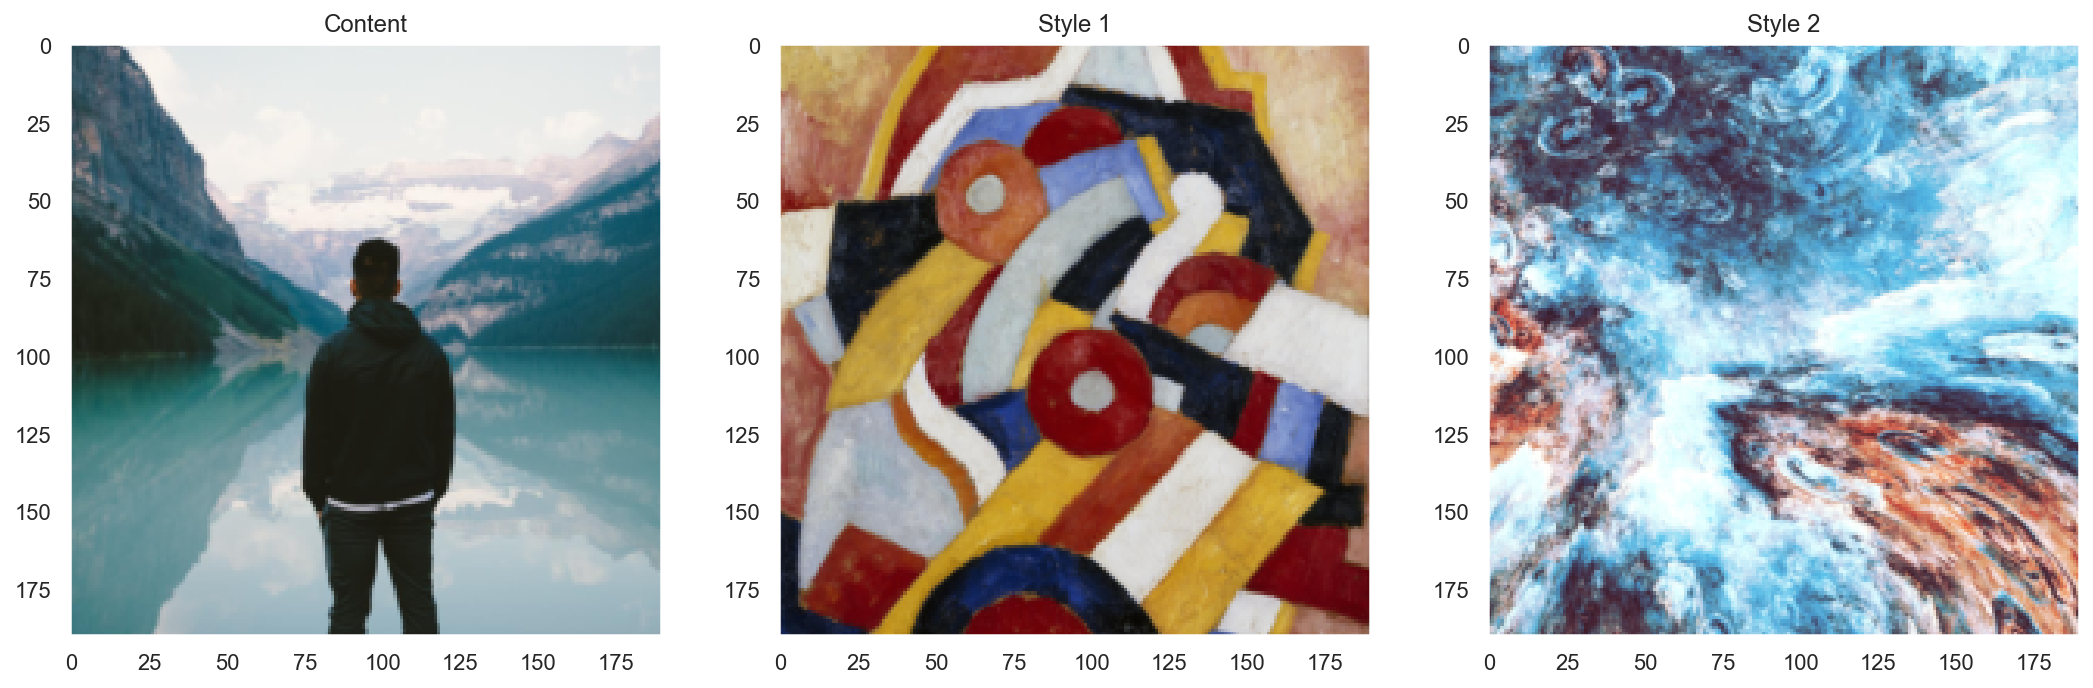

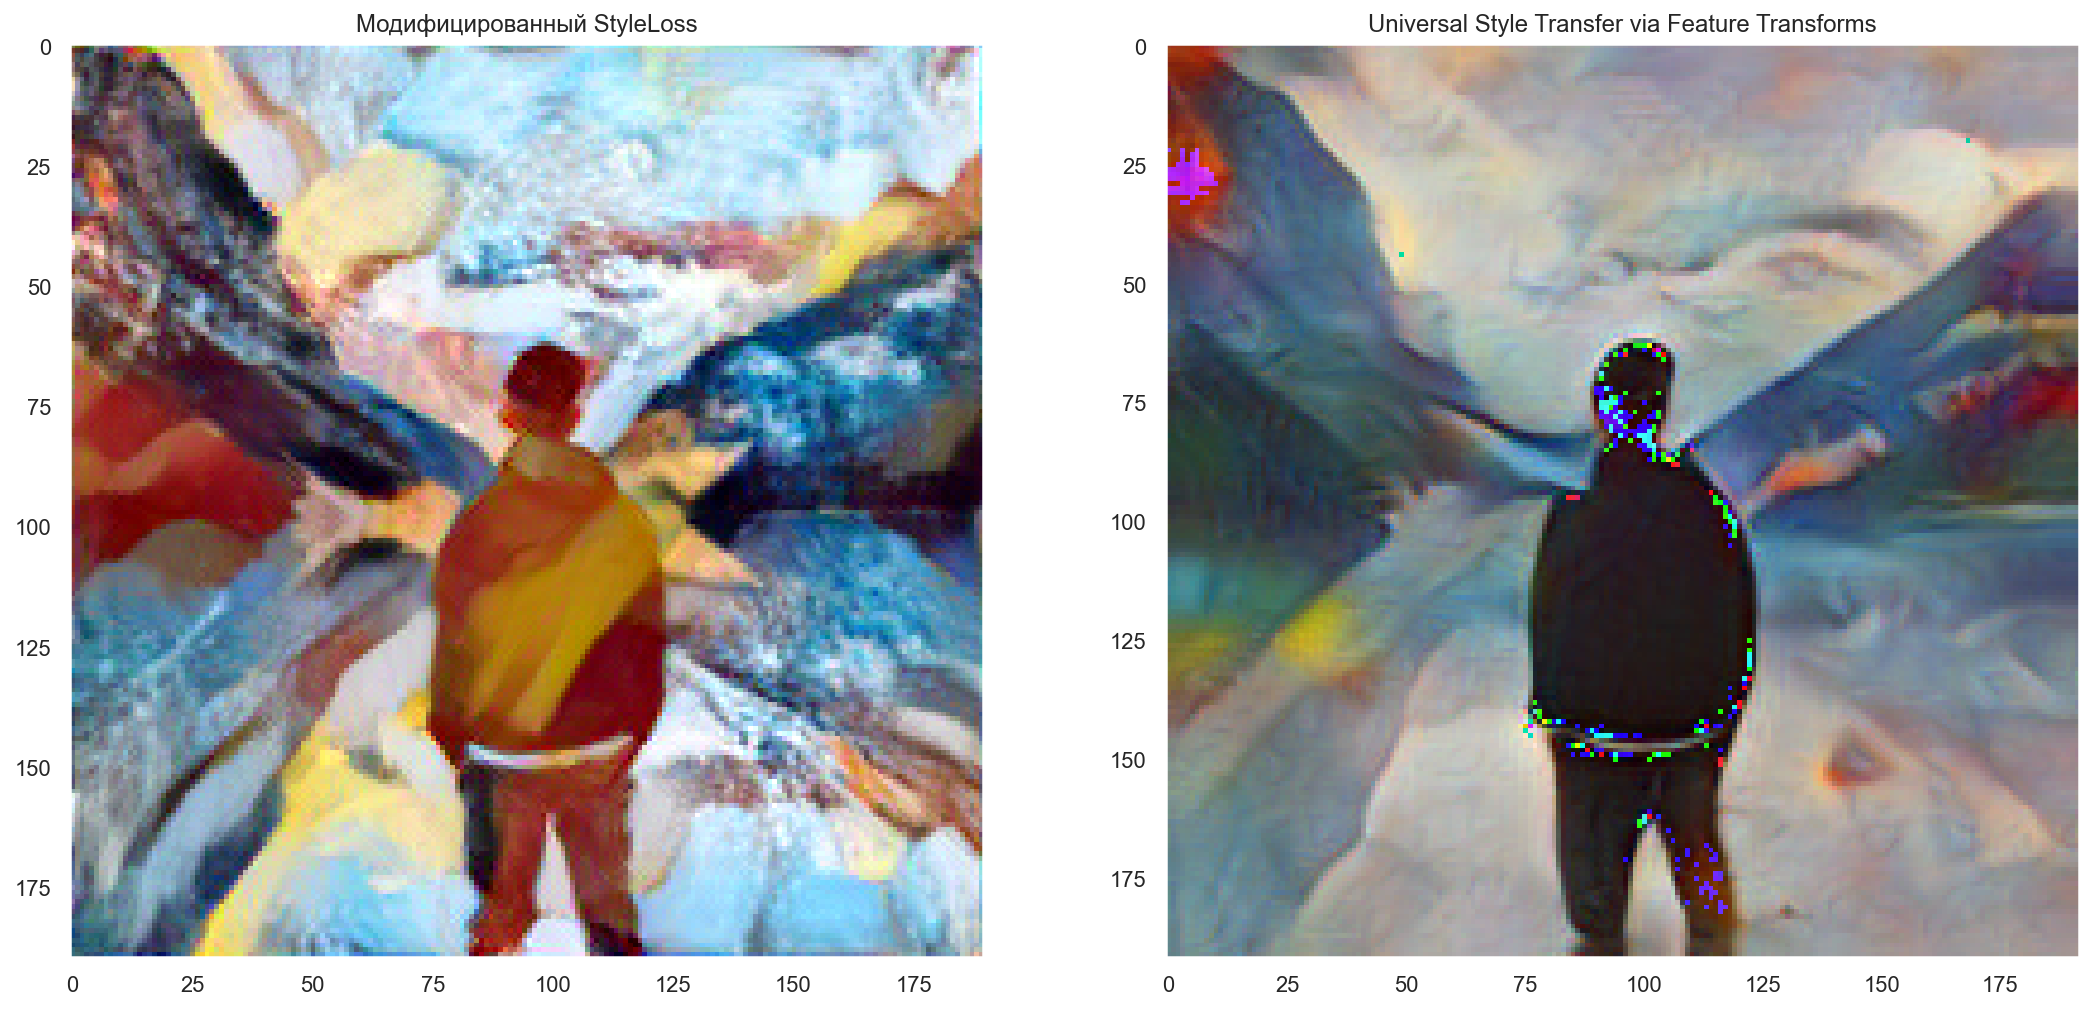

In [18]:
def showcase(content, style0, style1, out1, out2):
    sns.set(rc={"figure.figsize": (18, 14),
                "grid.linewidth": 0})

    # imshow(out)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)

    ax1.imshow(to_show(content))
    ax1.set_title('Content')
    ax2.imshow(to_show(style0))
    ax2.set_title('Style 1');
    ax3.imshow(to_show(style1))
    ax3.set_title('Style 2');
    # ax4.imshow(to_show(out))
    # ax4.set_title('Output');

    f2, (ax4, ax5) = plt.subplots(1, 2)
    ax4.imshow(to_show(out1))
    ax4.set_title('Модифицированный StyleLoss');
    ax5.imshow(to_show(out2));

    ax5.set_title('Universal Style Transfer via Feature Transforms');
    
showcase(content, style0, style1, output, out)

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 15507.092773 Content Loss: 14.747507

run [100]:
Style Loss : 15409.233398 Content Loss: 15.964676

run [150]:
Style Loss : 15371.928711 Content Loss: 16.623919

run [200]:
Style Loss : 15354.433594 Content Loss: 16.470825

run [250]:
Style Loss : 15346.208984 Content Loss: 15.732305

run [300]:
Style Loss : 15342.095703 Content Loss: 14.955225

run [350]:
Style Loss : 15339.937500 Content Loss: 14.278154

run [400]:
Style Loss : 15338.685547 Content Loss: 13.745590

run [450]:
Style Loss : 15337.952148 Content Loss: 13.333786

run [500]:
Style Loss : 15337.473633 Content Loss: 13.002432

run [550]:
Style Loss : 15337.141602 Content Loss: 12.742431

run [600]:
Style Loss : 15336.932617 Content Loss: 12.529586

run [650]:
Style Loss : 15336.782227 Content Loss: 12.349530

run [700]:
Style Loss : 15336.672852 Content Loss: 12.195358



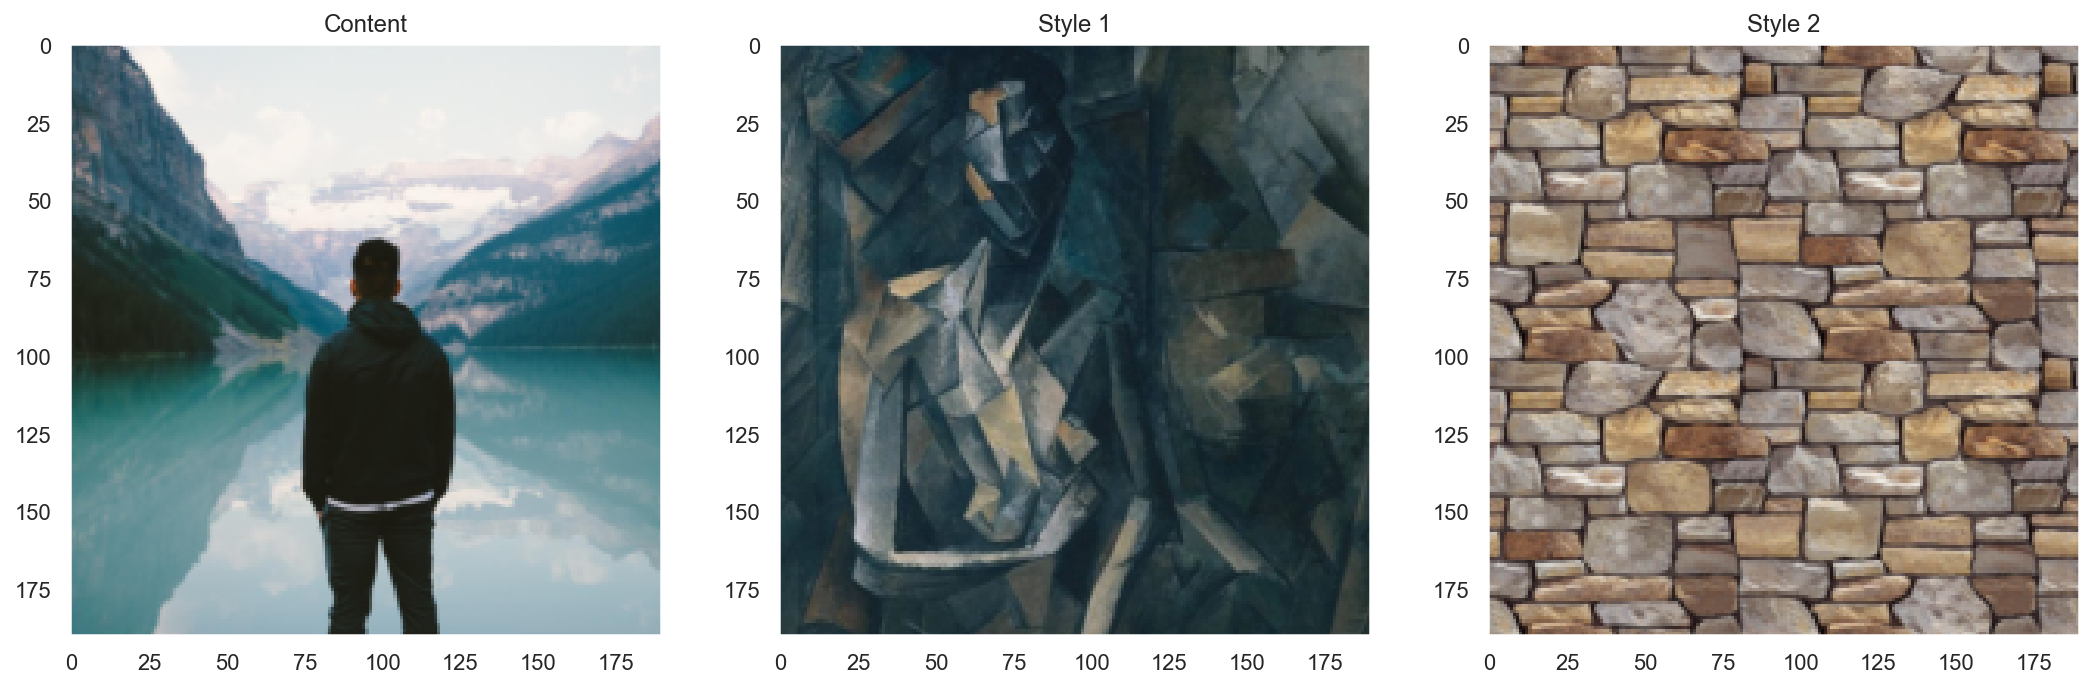

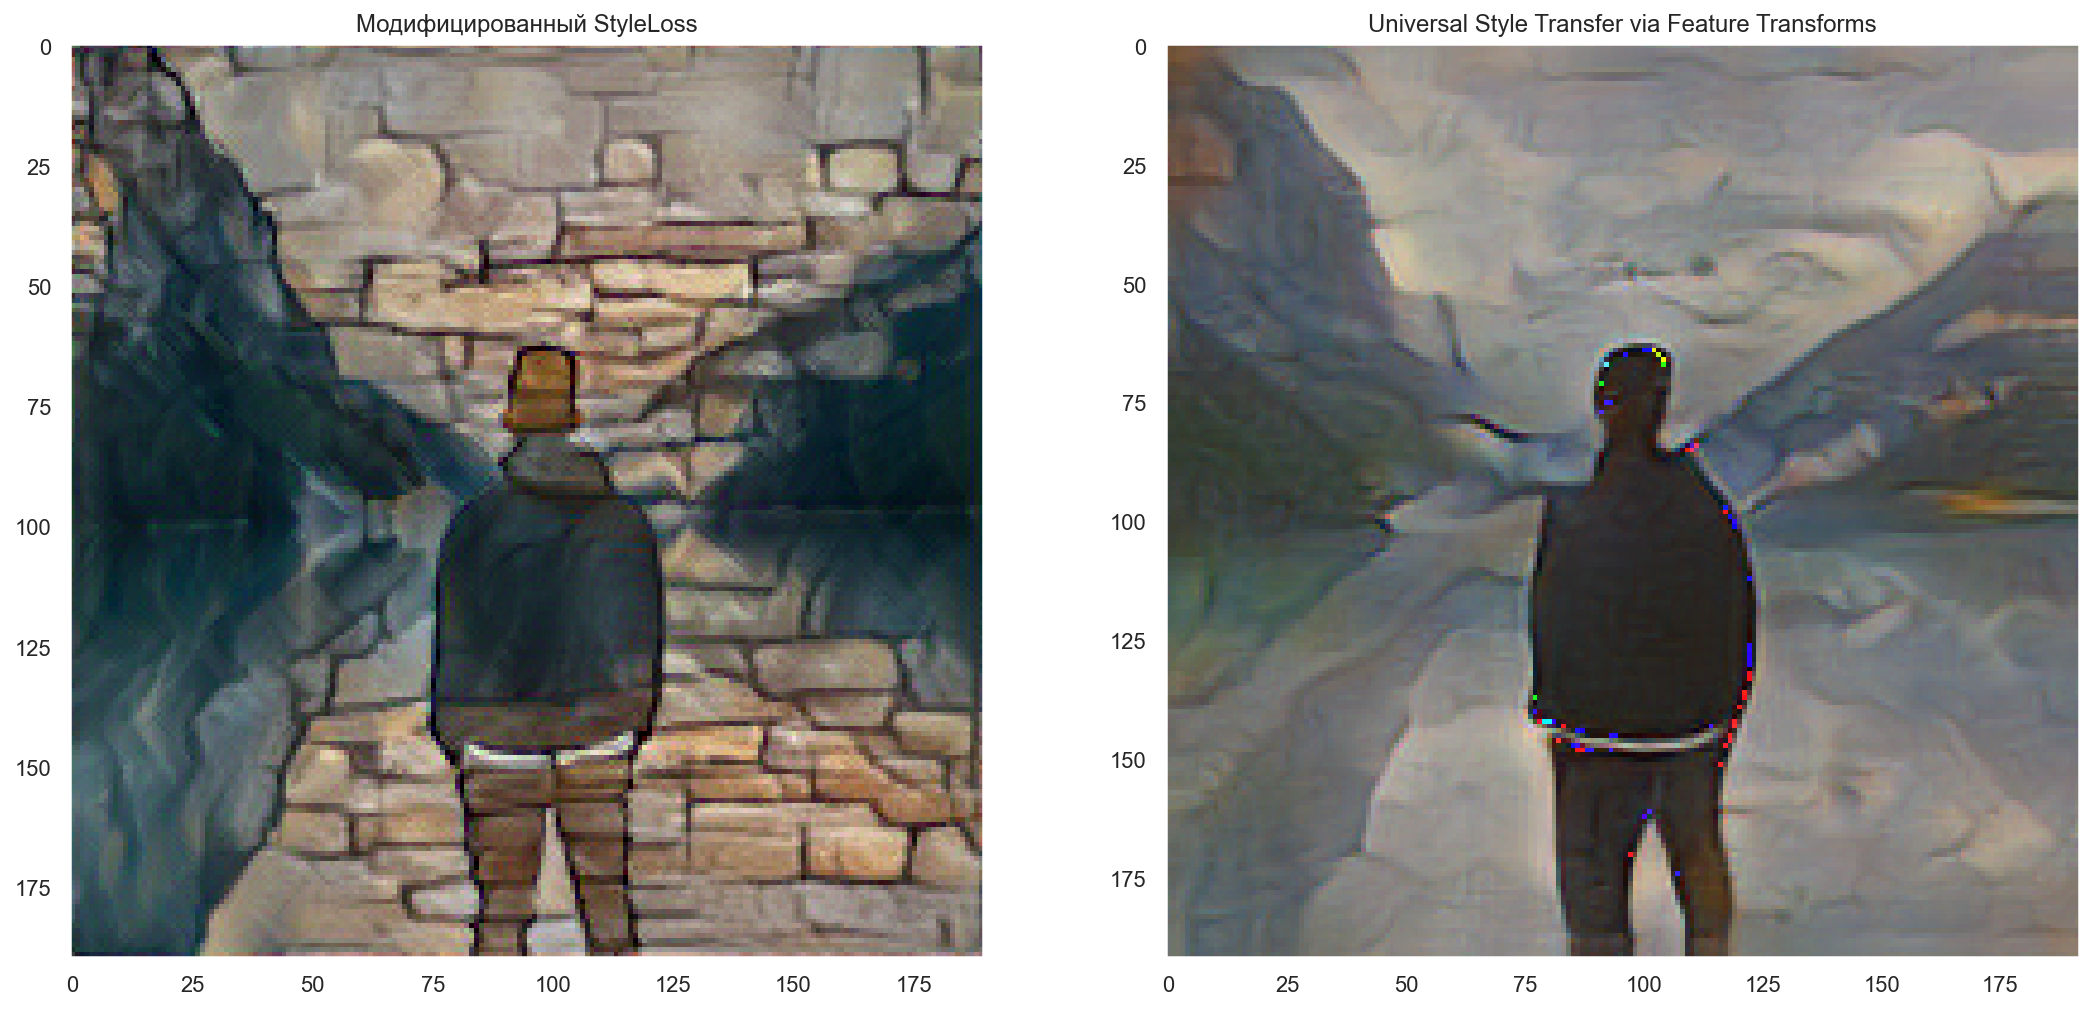

In [19]:
content_img = image_loader("images/man.jpg")
style_img = image_loader("images/picasso.jpg")
style_img2 = image_loader("images/brick.jpg")
input_img = content_img.clone()

output2 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, True, style_img2)

content = content_img.clone()
style0 = style_img.clone()
style1 = style_img2.clone()

model2 = MultiLevelWCT()
model2.to(device)
model2.eval()

out2 = model2(content, style0, True, style1)

showcase(content, style0, style1, output2, out2)

#### Сравним алгоритмы в крайних случаях

In [20]:
content_img = image_loader("images/man.jpg")
style_img = image_loader("images/cont.jpg")
style_img2 = image_loader("images/cont.jpg")
input_img = content_img.clone()

output3 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, True, style_img2)

content = content_img.clone()
style0 = style_img.clone()
style1 = style_img2.clone()

model3 = MultiLevelWCT()
model3.to(device)
model3.eval()

out3 = model(content, style0, True, style1)

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 2152.756592 Content Loss: 19.792099

run [100]:
Style Loss : 1385.320068 Content Loss: 25.483236

run [150]:
Style Loss : 1109.698364 Content Loss: 28.189556

run [200]:
Style Loss : 3218.431641 Content Loss: 32.074848

run [250]:
Style Loss : 11760.719727 Content Loss: 30.859650

run [300]:
Style Loss : 19439.425781 Content Loss: 34.293201

run [350]:
Style Loss : 729.835754 Content Loss: 32.814533

run [400]:
Style Loss : 45981676.000000 Content Loss: 457.495850

run [450]:
Style Loss : 3888.485840 Content Loss: 34.864216

run [500]:
Style Loss : 1882.921631 Content Loss: 34.127895

run [550]:
Style Loss : 895.830322 Content Loss: 33.627113

run [600]:
Style Loss : 541.516907 Content Loss: 33.036167

run [650]:
Style Loss : 269.765503 Content Loss: 32.893265

run [700]:
Style Loss : 214.092926 Content Loss: 32.834507



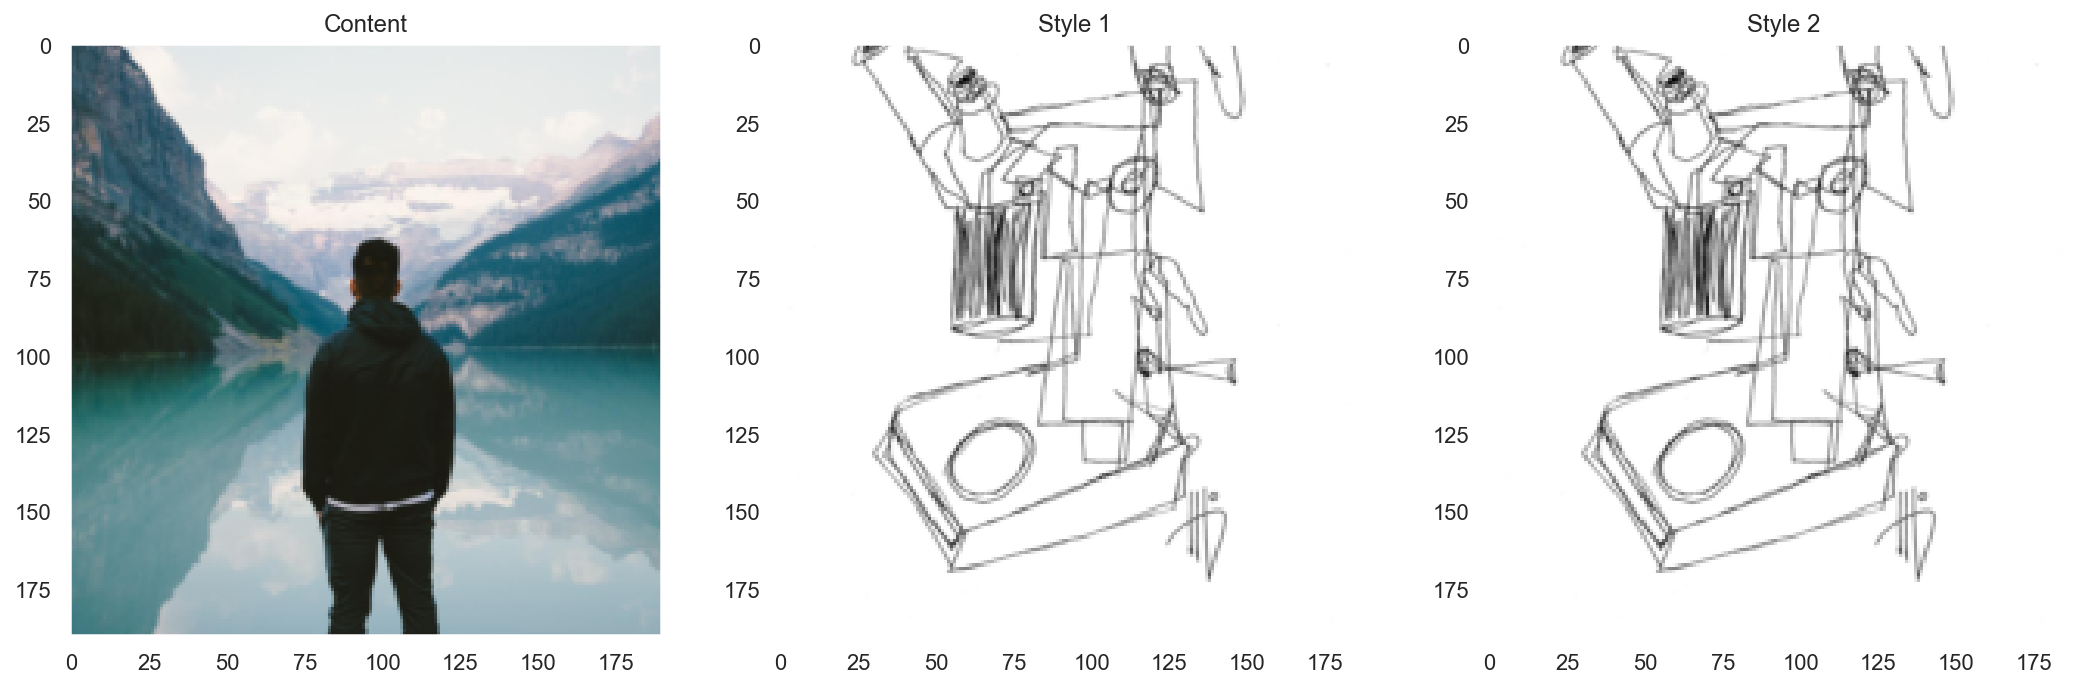

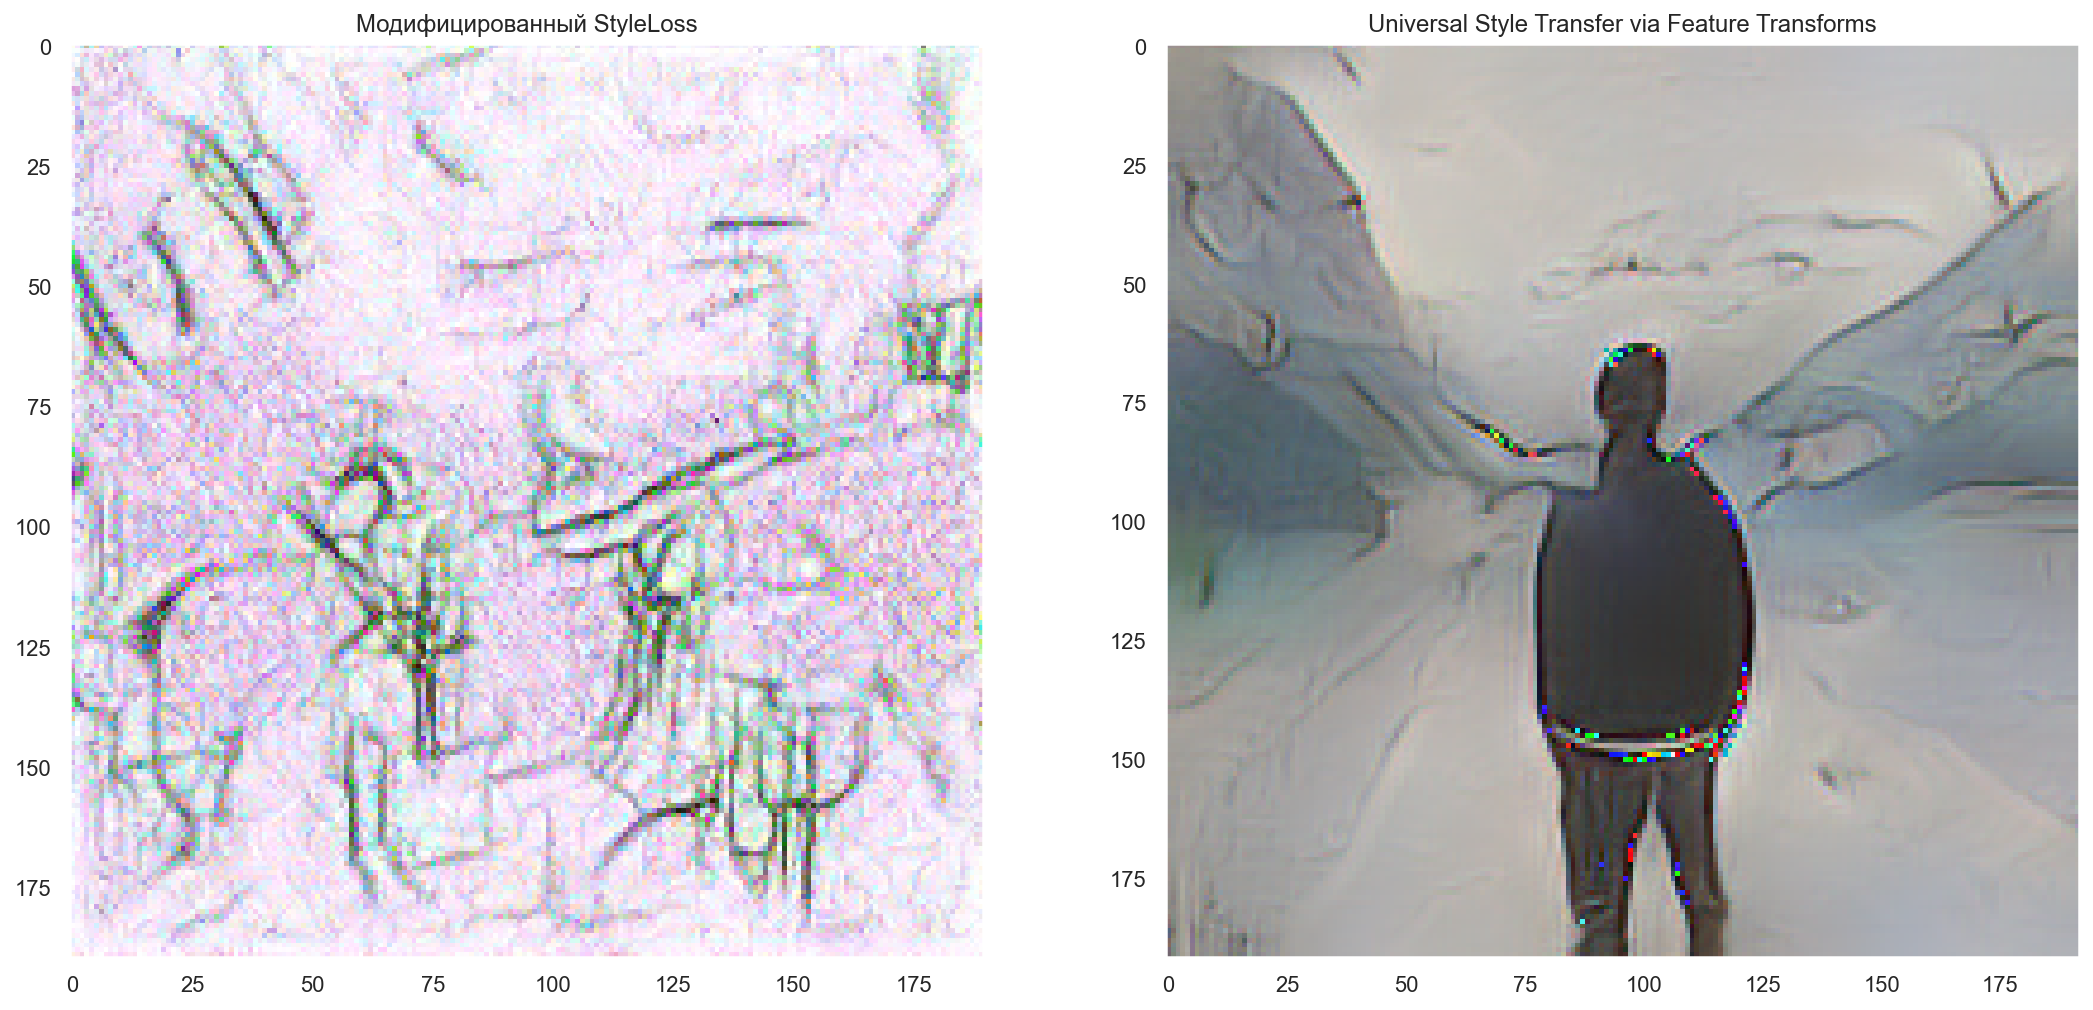

In [21]:
showcase(content, style0, style1, output3, out3)

# Вывод

**Видим, что Universal Style Transfer via Feature Transforms переводит стиль, сохраняя семантику объектов, но с некоторыми искажениями, которые можно объяснить претренированными decoder слоями на внешнем датасете. При этом реализация работает быстрее, чем просто модифицированный StyleLoss, хотя и реализация StyleLoss достаточно проста для неограниченного количества стилей.**